In [1]:
import sys
import math
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pathlib import Path

# Add parent directory to path to allow importing your local module
sys.path.append(str(Path("..").resolve()))

# Use your existing loader which handles the config structure correctly
from hyper_rbm import load_model

models_dir = Path("models")
results_dir = Path("results")
results_dir.mkdir(parents=True, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on: {device}")

Running on: cpu


In [2]:
import math
import numpy as np
import torch
from pathlib import Path

# --- HELPER FUNCTION ---
# We generally don't need a decorator here if the parent calls it,
# but it's safe to add it to ensure no graphs are built.
@torch.no_grad()
def metropolis_step_overlap(current_samples: torch.Tensor,
                            k: int,
                            scorer: callable,
                            current_score: torch.Tensor,
                            sync_flip_prob: float = 0.5):
    """
    Performs a single MCMC step for the Overlap Distribution P_k.
    INCLUDES SYNCHRONIZED GLOBAL FLIPS.
    """
    batch_size, num_v = current_samples.shape
    half = batch_size // 2
    device = current_samples.device

    # 1. Proposal
    is_global = torch.rand(1, device=device).item() < sync_flip_prob
    proposal = current_samples.clone()

    if is_global:
        # Synchronized Flip: Flip chain i AND its replica i+half simultaneously.
        flip_mask_half = torch.rand(half, device=device) < 0.5
        full_flip_mask = torch.cat([flip_mask_half, flip_mask_half], dim=0)
        proposal[full_flip_mask] = 1.0 - proposal[full_flip_mask]
    else:
        # Local Flip
        row_indices = torch.arange(batch_size, device=device)
        flip_indices = torch.randint(0, num_v, (batch_size,), device=device)
        proposal[row_indices, flip_indices] = 1.0 - proposal[row_indices, flip_indices]

    # 2. Evaluation Helper
    def compute_score(s):
        c1, c2 = s[:half], s[half:]
        # Clean Part
        log_psi_clean = scorer(torch.cat([c1, c2], dim=0))
        score_clean = log_psi_clean[:half] + log_psi_clean[half:]
        # Twisted Part (Swap first k)
        t1, t2 = c1.clone(), c2.clone()
        if k > 0:
            tmp = t1[:, :k].clone()
            t1[:, :k] = t2[:, :k]
            t2[:, :k] = tmp
        log_psi_twisted = scorer(torch.cat([t1, t2], dim=0))
        score_twisted = log_psi_twisted[:half] + log_psi_twisted[half:]
        return score_clean + score_twisted

    prop_score = compute_score(proposal)

    # 3. Acceptance
    log_alpha = prop_score - current_score
    log_uniform = torch.log(torch.rand(half, device=device))
    accept_mask = log_uniform < log_alpha

    full_mask = torch.cat([accept_mask, accept_mask], dim=0)
    current_samples[full_mask] = proposal[full_mask]
    current_score[accept_mask] = prop_score[accept_mask]

    return current_samples, current_score

# --- MAIN ESTIMATOR ---
# This decorator is the Critical Fix for the OOM error.
@torch.no_grad()
def estimate_improved_ratio_smooth(init_samples: torch.Tensor,
                                   max_l: int,
                                   scorer: callable,
                                   burn_in: int = 50,
                                   measure_steps: int = 20) -> dict:
    """
    Computes S2 using the Ratio Method with Averaging.
    Memory efficient (no gradient graph).
    """
    results = {}
    samples = init_samples.clone()
    batch_size = samples.shape[0]
    half = batch_size // 2

    # Initialize Score for k=0
    c1, c2 = samples[:half], samples[half:]
    log_psi = scorer(torch.cat([c1, c2], dim=0))
    current_score = 2.0 * (log_psi[:half] + log_psi[half:])

    entropy_accum = 0.0
    var_accum = 0.0

    for k in range(max_l):
        # 1. Burn-in: Relax into P_k
        for _ in range(burn_in):
            samples, current_score = metropolis_step_overlap(samples, k, scorer, current_score)

        # 2. Measure Average Ratio P_{k+1}/P_k
        log_ratios_list = []
        for _ in range(measure_steps):
            samples, current_score = metropolis_step_overlap(samples, k, scorer, current_score)

            # Recompute twist scores to get ratio
            c1_curr, c2_curr = samples[:half], samples[half:]

            # Twist k
            t1, t2 = c1_curr.clone(), c2_curr.clone()
            if k > 0: t1[:, :k], t2[:, :k] = t2[:, :k].clone(), t1[:, :k].clone()
            s_twist_k_raw = scorer(torch.cat([t1, t2]))
            s_twist_k = s_twist_k_raw[:half] + s_twist_k_raw[half:]

            # Twist k+1
            t1[:, k], t2[:, k] = t2[:, k].clone(), t1[:, k].clone()
            s_twist_kp1_raw = scorer(torch.cat([t1, t2]))
            s_twist_kp1 = s_twist_kp1_raw[:half] + s_twist_kp1_raw[half:]

            log_ratios_list.append(s_twist_kp1 - s_twist_k)

        # 3. Aggregate
        all_log_ratios = torch.stack(log_ratios_list).flatten()
        max_log = torch.max(all_log_ratios)
        mean_r = torch.exp(max_log) * torch.mean(torch.exp(all_log_ratios - max_log))

        step_s2 = -torch.log(mean_r).item()
        entropy_accum += step_s2

        # Error
        var_r = torch.var(torch.exp(all_log_ratios))
        step_err_sq = (var_r / (mean_r**2) / all_log_ratios.numel()).item()
        var_accum += step_err_sq

        results[k+1] = (entropy_accum, math.sqrt(var_accum))

    return results

In [3]:
# UPDATE FILENAME HERE
model_filename = "hyprbm_tfim_16_20000_20260118_193918.pt"
model_path = models_dir / model_filename

print(f"Loading checkpoint: {model_path.name}")

# Use the robust loader from your file
model, config = load_model(model_path, device)

CHAIN_LENGTH = int(model.num_v)
h_support_vals = sorted(config.get("h_support", []))
print(f"Model L={CHAIN_LENGTH}. Support points: {h_support_vals}")

# Load Reference
ref_file = Path(f"tfim_{CHAIN_LENGTH}_entangle_ref.csv")
try:
    ref_df = pd.read_csv(ref_file)
    print("ED Reference Data Loaded.")
except:
    ref_df = None
    print("No reference file found.")

Loading checkpoint: hyprbm_tfim_16_20000_20260118_193918.pt
Model L=16. Support points: [0.5, 0.8, 0.95, 1.0, 1.05, 1.2, 1.5]
ED Reference Data Loaded.


In [4]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# --- Tuning Parameters ---
ANNEAL_STEPS = 500       # Global burn-in (Physics)
TOTAL_SAMPLES = 20_000   # Number of parallel chains
BURN_IN_STEPS = 60       # Local burn-in (Adapt to k)
MEASURE_STEPS = 20       # Smoothing steps (Fixes jaggedness)
DENSE_RES = 0.05

# Define Grid
h_novel_vals = np.arange(min(h_support_vals), max(h_support_vals) + 0.01, DENSE_RES)
all_h_values = sorted(list(set(h_support_vals) | set(h_novel_vals)))

print(f"Scanning h: {len(all_h_values)} points.")
print(f"N={TOTAL_SAMPLES} | BurnIn={BURN_IN_STEPS} | AvgSteps={MEASURE_STEPS}")

results_list = []
max_l = CHAIN_LENGTH // 2
rng_eval = torch.Generator(device=device).manual_seed(SEED)
model_dtype = next(model.parameters()).dtype

for h_val in all_h_values:
    split = "support" if any(np.isclose(h_val, s, atol=1e-3) for s in h_support_vals) else "interpolated"
    print(f"h={h_val:.2f}...", end="", flush=True)

    # 1. Phase 1: Global Anneal
    cond_batch = torch.full((TOTAL_SAMPLES, 1), h_val, device=device, dtype=model_dtype)
    schedule = torch.tensor([1.0] * ANNEAL_STEPS, device=device, dtype=model_dtype)

    with torch.no_grad():
        base_samples = model.generate(cond_batch, schedule, rng=rng_eval)

    # 2. Phase 2: Smooth Improved Ratio
    def scorer(v):
        c = torch.full((v.shape[0], 1), h_val, device=v.device, dtype=v.dtype)
        return model.log_score(v, c)

    chain_results = estimate_improved_ratio_smooth(
        base_samples,
        max_l,
        scorer,
        burn_in=BURN_IN_STEPS,
        measure_steps=MEASURE_STEPS
    )

    for l, (val, err) in chain_results.items():
        results_list.append({"h": float(h_val), "l": int(l), "s2": val, "s2_err": err, "type": split})

    print(f" S2(L/2)={chain_results[max_l][0]:.4f}")

results_df = pd.DataFrame(results_list)

Scanning h: 27 points.
N=20000 | BurnIn=60 | AvgSteps=20
h=0.50... S2(L/2)=4.4207
h=0.55... S2(L/2)=4.1657
h=0.60... S2(L/2)=3.7685
h=0.65... S2(L/2)=3.6171
h=0.70... S2(L/2)=3.2805
h=0.75... S2(L/2)=2.8314
h=0.80... S2(L/2)=2.4538
h=0.80... S2(L/2)=2.4772
h=0.85... S2(L/2)=2.0181
h=0.90... S2(L/2)=1.7058
h=0.95... S2(L/2)=1.3377
h=0.95... S2(L/2)=1.3427
h=1.00... S2(L/2)=0.9557
h=1.00... S2(L/2)=0.9848
h=1.05... S2(L/2)=0.7349
h=1.05... S2(L/2)=0.7124
h=1.10... S2(L/2)=0.5106
h=1.15... S2(L/2)=0.3900
h=1.20... S2(L/2)=0.3129
h=1.20... S2(L/2)=0.2934
h=1.25... S2(L/2)=0.2745
h=1.30... S2(L/2)=0.1991
h=1.35... S2(L/2)=0.1837
h=1.40... S2(L/2)=0.1858
h=1.45... S2(L/2)=0.1531
h=1.50... S2(L/2)=0.1287
h=1.50... S2(L/2)=0.1561


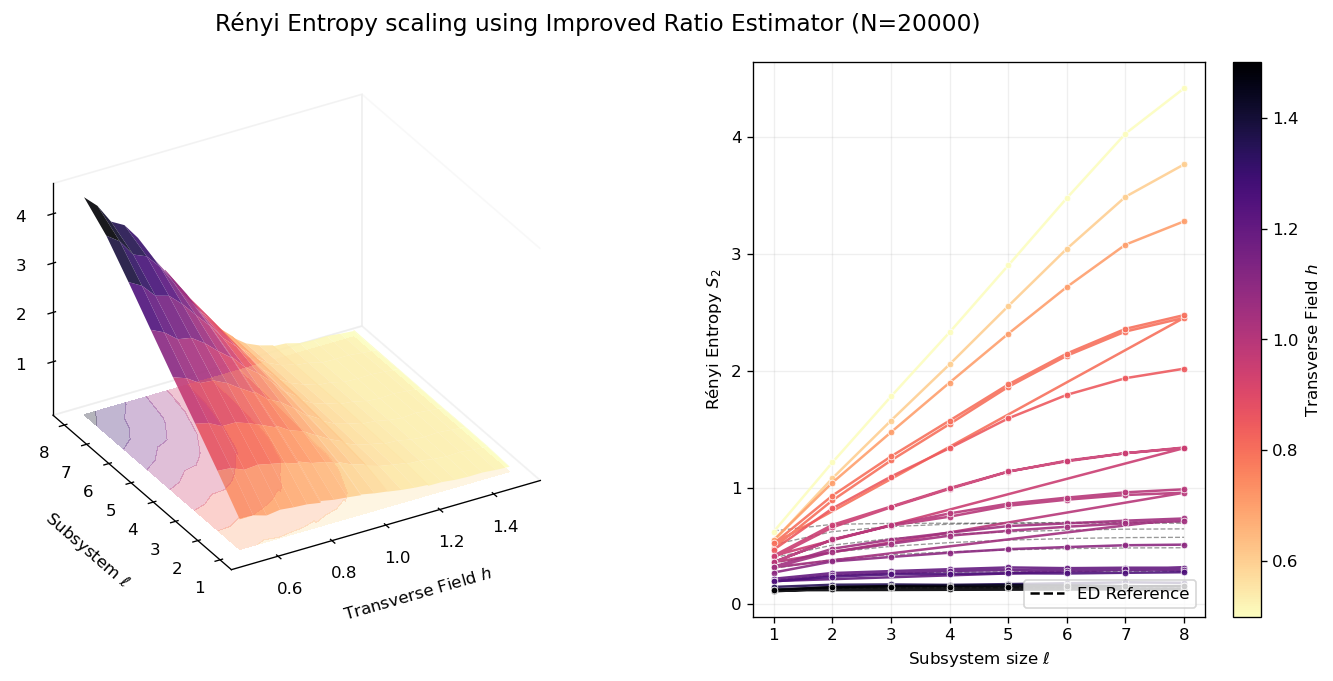

In [5]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Prep Data
pivot_df = results_df.pivot(index='l', columns='h', values='s2')
pivot_df = pivot_df.sort_index().sort_index(axis=1)

h_dense = pivot_df.columns.to_numpy(dtype=float)
l_values = pivot_df.index.to_numpy(dtype=float)
X_h, Y_l = np.meshgrid(h_dense, l_values)
Z_s2 = pivot_df.to_numpy(dtype=float)

# Setup
fig = plt.figure(figsize=(15, 6), dpi=120)
gs = gridspec.GridSpec(1, 2, width_ratios=[1.3, 1], wspace=0.15)
cmap = cm.magma_r

# --- Left: 3D Surface ---
ax3d = fig.add_subplot(gs[0], projection='3d')
ax3d.set_proj_type('ortho')

# Plot Surface
surf = ax3d.plot_surface(X_h, Y_l, Z_s2, cmap=cmap, edgecolor='none', alpha=0.9, antialiased=True)
# Add Floor Contour
ax3d.contourf(X_h, Y_l, Z_s2, zdir='z', offset=np.nanmin(Z_s2)-0.1, cmap=cmap, alpha=0.3)

ax3d.set_zlim(np.nanmin(Z_s2)-0.1, np.nanmax(Z_s2)+0.1)
ax3d.set_xlabel("Transverse Field $h$", labelpad=10)
ax3d.set_ylabel("Subsystem $\ell$", labelpad=10)
ax3d.set_zlabel("$S_2$", labelpad=10)
ax3d.view_init(elev=30, azim=-120)
ax3d.grid(False)
ax3d.xaxis.pane.fill = False; ax3d.yaxis.pane.fill = False; ax3d.zaxis.pane.fill = False

# --- Right: 2D Curves ---
ax2d = fig.add_subplot(gs[1])
norm = mcolors.Normalize(vmin=min(h_dense), vmax=max(h_dense))

# Plot Reference (Dashed)
if ref_df is not None:
    ref_h = sorted(ref_df['h'].unique())
    for rh in ref_h:
        if rh < min(h_dense) or rh > max(h_dense): continue
        row = ref_df[np.isclose(ref_df['h'], rh)].iloc[0]
        l_cols = sorted([c for c in ref_df.columns if c.startswith('l') and int(c[1:]) in l_values], key=lambda x: int(x[1:]))
        ax2d.plot([int(c[1:]) for c in l_cols], row[l_cols], 'k--', lw=0.8, alpha=0.4, zorder=1)
    ax2d.plot([], [], 'k--', label='ED Reference')

# Plot Model Results (Colored)
step = max(1, len(h_dense)//12)
for h in h_dense[::step]:
    subset = results_df[np.isclose(results_df['h'], h)]
    ax2d.errorbar(subset['l'], subset['s2'], yerr=subset['s2_err'],
                  color=cmap(norm(h)), fmt='-o', ms=4, lw=1.5, alpha=0.9,
                  markeredgecolor='white', markeredgewidth=0.5)

ax2d.set_xlabel(r"Subsystem size $\ell$")
ax2d.set_ylabel(r"Rényi Entropy $S_2$")
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax2d)
cbar.set_label("Transverse Field $h$")

if ref_df is not None: ax2d.legend(loc='lower right')
ax2d.grid(True, alpha=0.2)

plt.suptitle(f"Rényi Entropy scaling using Improved Ratio Estimator (N={TOTAL_SAMPLES})", y=0.95, fontsize=14)
plt.show()